In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import os
import json
import csv
import math
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import cv2
from tqdm.notebook import tqdm
import glob
import random
import collections
import gc
from PIL import Image
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print(torch.__version__)

1.3.1


In [2]:
with open('adjs.json', 'r') as filehandle:
    adjs = json.load(filehandle)
with open('pnames.json', 'r') as filehandle:
    pnames = json.load(filehandle)
    
GPUS = torch.cuda.device_count()
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

def get_name():
   return  random.sample(adjs, 1)[0] + "_" + random.sample(pnames, 1)[0] 
get_name()


data_dir = '/home/ec2-user/dfdc/dfdc_ds/frames'
img_dir = ''
REAL = 0
FAKE = 1

meta = pd.read_csv(f'{data_dir}/metadata.csv', converters= {
    'label': lambda x: FAKE if x == 'FAKE' else REAL,
    'filename': lambda v: v.replace('.mp4', ''),
    'original': lambda v: v.replace('.mp4', ''),
    'folder': lambda v: int(v.split('_')[-1])
})

print(meta[meta['filename'].isin(['vulukprfvv', 'oebaztypsg'])].index)
meta = meta.drop([79200, 79319])
meta['label'].value_counts()
realOnly = meta[meta['label'] == REAL].sort_values(by='folder')
print(len(realOnly))
allByFolder = meta.groupby('folder')
# allByFolder.count()
# pd.crosstab(meta['folder'], meta['label'], normalize='index').round(4) * 100
#pd.crosstab(meta['folder'], meta['label'])


Int64Index([79200, 79319], dtype='int64')
19154


# HYPER PARAMS

In [27]:
#=======================
SQR_IMG_SIDE=500     
#=======================
ARCH = 'resnext50_32x4d'
#arch = 'resnet18'  
TRAIN_BACK_TO = None
if (GPUS > 1):
    TRAIN_BACK_TO = "module.layer2.0.conv1.weight"
else:
    TRAIN_BACK_TO = "layer2.0.conv1.weight"
DROP_OUT = 0.2
#=======================
# x 2 (we only specify fake)
FAKE_TRAIN_SIZE = 5_000 
TOTAL_TRAIN_SIZE = 10_000
VAL_SEED = 991
VAL_FOLDERS = range(30, 49)
#================================
BATCH_SIZE = 32
EPOCHS = 25
NUM_WORKERS = 16
PIN = True
if GPUS > 1:
  BATCH_SIZE = 160
  PIN = True
  NUM_WORKERS = 48

# see 'LR Finder' section below, this is just an arbitrary point between
# lr max and min based on the LR/Loss graph
LR = 7e-4
OPTIMIZER = torch.optim.SGD
#==================================

In [4]:

def build_train_sample(size=2500, seed=None):
    trainByFolderAndOriginal = meta[~meta['folder']
                                .isin(VAL_FOLDERS)
                               ].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new train/val split
    randomized_pairs = trainByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    OneFakePerOriginal = OneFakePerOriginal.sample(size)
    realOfFake = OneFakePerOriginal['original']
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    t_fake = OneFakePerOriginal
    t_real = OneFakePerOriginal.copy()
    t_real = t_real.drop(columns=['filename'])
    t_real = t_real.rename(columns={"original":"filename"})
    t_real['label'] = 0
    print(len(t_fake), len(t_real))
    train = pd.concat([t_fake, t_real])
    return train

def build_train_df(seed=None):
    trainByFolderAndOriginal = meta[~meta['folder']
                                    .isin(VAL_FOLDERS)
                                   ].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new train/val split
    randomized_pairs = trainByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    OneFakePerOriginal.head()
    t_fake = OneFakePerOriginal
    t_real = realOnly[~realOnly['folder'].isin(VAL_FOLDERS)]
    print(len(t_fake), len(t_real))
    train = pd.concat([t_fake, t_real])
    return train
    
def build_val_df(seed=999):
    valByFolderAndOriginal = meta[meta['folder']
                                  .isin(VAL_FOLDERS)].groupby(['folder', 'original'])
    np.random.seed(seed) # change this for new val split
    randomized_pairs = valByFolderAndOriginal.agg(np.random.choice)
    np.random.seed()
    flattened = randomized_pairs.reset_index()
    flattened.head()
    OneFakePerOriginal = flattened.drop(flattened[flattened.original == ''].index)
    print(len(OneFakePerOriginal)) # should be equivelant to the # of real videos far above!
    OneFakePerOriginal.head()
    v_fake = OneFakePerOriginal
    v_real = realOnly[realOnly['folder'].isin(VAL_FOLDERS)]
    print(len(v_fake), len(v_real))
    val = pd.concat([v_fake, v_real])
    return val


In [5]:
from torch.utils.data import Dataset
from torchvision.transforms import Normalize
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class Unnormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor * std + mean, 0., 1.)
    
unnormalize_transform = Unnormalize(mean, std)

def resize_image(img, size):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h))
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

import time as t
timer = True

def load_image_and_label(filename, cls, crops_dir, folder_num, image_size, augment):
    """Loads an image into a tensor. Also returns its label."""
    try:
        files = os.listdir(f'{crops_dir}/dfdc_train_part_{str(folder_num)}/{filename}')
        # only randomize frame per video in training set
        if augment:
            np.random.seed()
            p = np.random.choice(np.array(files))
        else:
            np.random.seed(99)
            p = np.random.choice(np.array(files))
            np.random.seed()

        img = cv2.imread(os.path.join(crops_dir, f'dfdc_train_part_{folder_num}', filename, p))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if (img.shape[0] > img.shape[1]):
            img = img[0: int(img.shape[0] - (img.shape[0] * 0.30)), :]
        else:
            img = img[:, 0 + int(img.shape[1] * 0.15): int(img.shape[1] - img.shape[1] * 0.15)]
        img = resize_image(img, image_size)
        if augment: 
            im_pil = Image.fromarray(img)
            train_trans = transforms.Compose([
                transforms.RandomRotation(degrees=10),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0)
            ])
            img = train_trans(im_pil)
            img = np.asarray(img)

        img = make_square_image(img)
        generic_trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        img = generic_trans(img)
        target = cls
        return img, target
    except:
        print(f'failed to load file: {filename}, folder: {folder_num}')
        raise


class MyDataset(Dataset):
    def __init__(self, crops_dir, df, split, image_size, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        self.df = df
        num_real = len(self.df[self.df["label"] == REAL])
        num_fake = len(self.df[self.df["label"] == FAKE])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["filename"]
        cls = row["label"]
        folder_num = row['folder']
        return load_image_and_label(filename, 
                                    cls, 
                                    self.crops_dir, 
                                    folder_num,
                                    self.image_size, 
                                    self.split == "train")
    def __len__(self):
        return len(self.df)

# Training Loops

In [ ]:
def evaluate(net, data_loader, device, silent=False):
    net.train(False)
    bce_loss = 0
    total_examples = 0

    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()

                y_pred = net(x)
                y_pred = y_pred.squeeze()

                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size

            total_examples += batch_size
            pbar.update()

    bce_loss /= total_examples
    return bce_loss

In [7]:
fieldnames = ['epoch', 'batch_size', 'lr', 'tloss', 'vloss']
def init_log():
     with open(f'{name}_{GPUS}xGPU_{ARCH}.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
def log_epoch(data):
    with open(f'{name}_{GPUS}xGPU_{ARCH}.csv', 'a') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if (data is not None):
            writer.writerow(data)


In [8]:
def fit(epochs, cp=True, log=True):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(tdl), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            bce_loss = 0
            total_examples = 0
            net.train(True)
            for batch_idx, data in enumerate(tdl):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                
                optimizer.zero_grad()

                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)
                total_examples += batch_size
                iloss = round(bce_loss / total_examples, 4)
                pbar.set_description(f"Epoch {epochs_done + 1} (loss:{iloss}) ")
                
                ## LR scheduler TBD ##
        
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1

            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

            val_bce_loss = evaluate(net, vdl, device=gpu, silent=False)
            history["val_bce"].append(val_bce_loss)
            
            print("              val BCE: %.4f" % (val_bce_loss))
            
            
            if (log):
                log_epoch({
                    'epoch': epochs_done,
                    'batch_size': batch_size,
                    'lr': LR,
                    'tloss': bce_loss,
                    'vloss': val_bce_loss
                })
            
            if (cp == True 
                and (len(history['val_bce']) == 0 
                     or val_bce_loss <= np.min(np.array(history['val_bce'])))
               ):
                if hasattr(net, 'module'):
                    torch.save({
                            'epoch': epochs_done,
                            'model_state_dict': net.module.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_bce_loss
                            }, f"{name}.ckpt.pth")
                    print(f'saved: {name}.ckpt.pth')
                else:
                    torch.save({
                            'epoch': epochs_done,
                            'model_state_dict': net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': val_bce_loss
                            }, f"{name}.ckpt.pth")
                    print(f'saved: {name}.ckpt.pth')
    

# Model 

In [9]:
import torchvision.models as models
import torch.nn as nn

##Load new model
def get_model(pretrained = True, model=''):
    model = torch.hub.load('pytorch/vision:v0.5.0', 
                           ARCH, 
                           pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(DROP_OUT),
        nn.Linear(num_ftrs, 1)
    )
    return model

def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [10]:
def load_model_from_checkpoint(name):
    model = get_model(False)
    name = f'{name}.ckpt.pth'
    checkpoint = torch.load(name)
    model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch



# Training Data loader Parameters

In [11]:
train = build_train_sample(size=FAKE_TRAIN_SIZE)
val = build_val_df(VAL_SEED)
val.head()
val_len = len(val)
train_len = len(train)

5000
5000 5000
8091
8091 8091


10000 16182
['vnrjpyqjxd' 17 1920 1 'egzyxqihni' 'train' 1080]


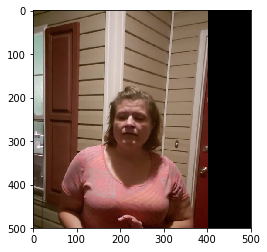

In [12]:
print(train_len, val_len)
r = train.sample().values[0]
print(r)
img_tensor, label = load_image_and_label(r[0], 1, data_dir, r[1], SQR_IMG_SIDE, False)
plt.imshow(unnormalize_transform(img_tensor).permute(1, 2, 0))

In [13]:
train_ds = MyDataset(data_dir, train, 'train', SQR_IMG_SIDE)
val_ds = MyDataset(data_dir, val, 'val', SQR_IMG_SIDE)

train dataset has 5000 real videos, 5000 fake videos
val dataset has 8091 real videos, 8091 fake videos


In [14]:
%%time
def create_data_loaders():
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=NUM_WORKERS, pin_memory=PIN)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, 
                            num_workers=NUM_WORKERS, pin_memory=PIN)

    return train_loader, val_loader

tdl, vdl = create_data_loaders()



CPU times: user 122 µs, sys: 5 µs, total: 127 µs
Wall time: 134 µs


In [ ]:
# vit = iter(vdl)
# X, y = next(vit)
# plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
# print(y[0])
# del vit

In [ ]:
# itr = iter(tdl)
# X, y = next(itr)
# print(X.size())
# plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
# print(y[0])
# del itr
# del X
# del y

# Training 

In [15]:
name = get_name()
init_log()
name

'versed_Deino'

In [16]:
history = { "train_bce": [], "val_bce": [] }
iteration = 0

In [ ]:
# Load existing model to resume
#  model, epochs_done = load_model_from_checkpoint()

In [17]:
# Load new Model
model = get_model(True)
epochs_done = 0

Using cache found in /home/ec2-user/.cache/torch/hub/pytorch_vision_v0.5.0


In [18]:
if GPUS > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)
net = model.to(gpu)

In [19]:
freeze_until(net, TRAIN_BACK_TO)

In [20]:
[k for k,v in net.named_parameters() if v.requires_grad]

['layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.conv3.weight',
 'layer2.0.bn3.weight',
 'layer2.0.bn3.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.weight',
 'layer2.0.downsample.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer2.1.conv3.weight',
 'layer2.1.bn3.weight',
 'layer2.1.bn3.bias',
 'layer2.2.conv1.weight',
 'layer2.2.bn1.weight',
 'layer2.2.bn1.bias',
 'layer2.2.conv2.weight',
 'layer2.2.bn2.weight',
 'layer2.2.bn2.bias',
 'layer2.2.conv3.weight',
 'layer2.2.bn3.weight',
 'layer2.2.bn3.bias',
 'layer2.3.conv1.weight',
 'layer2.3.bn1.weight',
 'layer2.3.bn1.bias',
 'layer2.3.conv2.weight',
 'layer2.3.bn2.weight',
 'layer2.3.bn2.bias',
 'layer2.3.conv3.weight',
 'layer2.3.bn3.weight',
 'layer2.3.bn3.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn

### Fit

In [28]:
optimizer = OPTIMIZER(net.parameters(), lr = LR, momentum=0.9) 
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0007
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [29]:
# epochs done is subtracted in case of interruption
fit(EPOCHS - epochs_done)

Epoch:  21, train BCE: 0.1714


BCE: 0.4469
              val BCE: 0.4469
saved: versed_Deino.ckpt.pth
Epoch:  22, train BCE: 0.1586


BCE: 0.4768
              val BCE: 0.4768
Epoch:  23, train BCE: 0.1600


BCE: 0.4727
              val BCE: 0.4727
Epoch:  24, train BCE: 0.1591


BCE: 0.4733
              val BCE: 0.4733
Epoch:  25, train BCE: 0.1552


BCE: 0.5006
              val BCE: 0.5006


# LR Finder

https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

https://github.com/TDehaene/blogposts/blob/master/learning_rates/notebooks/Model%20training.ipynb


In [ ]:
tnet = get_model(True).to(gpu)

In [ ]:
freeze_until(tnet, TRAIN_BACK_TO)
START_LR = 1e-6
END_LR = 0.1
SMOOTHING_LR_LOSS = 0.05
LR_FIND_EPOCHS = 2
lr_lambda = lambda x: math.exp(x * math.log(END_LR / START_LR) / (LR_FIND_EPOCHS * len(tdl)))
optimizer = OPTIMIZER(tnet.parameters(), lr = START_LR) 
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

In [ ]:

def lr_finder(epochs, cp=True, log=True):
    lr_history = { "train_bce": [],"lr_loss": [], "lr_steps": [] }
    iteration = 0
    epochs_done = 0
    with tqdm(total=len(tdl), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            bce_loss = 0
            total_examples = 0
            tnet.train(True)
            for batch_idx, data in enumerate(tdl):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                optimizer.zero_grad()
                y_pred = tnet(x)
                y_pred = y_pred.squeeze()
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                lr_history["train_bce"].append(batch_bce)
                total_examples += batch_size
                iloss = round(bce_loss / total_examples, 4)
                pbar.set_description(f"Epoch {epochs_done + 1} (loss:{iloss}) ")
                
                ## LR scheduler
                lr_scheduler.step()
                lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                lr_history["lr_steps"].append(lr_step)

                # smooth the loss
                if iteration == 0:
                  lr_history["lr_loss"].append(batch_bce)
                else:
                  lr_loss = SMOOTHING_LR_LOSS  * batch_bce \
                        + (1 - SMOOTHING_LR_LOSS) * lr_history["lr_loss"][-1]
                  lr_history["lr_loss"].append(lr_loss)
        
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1
            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

    return lr_history

In [ ]:
h = lr_finder(LR_FIND_EPOCHS)
del tnet
del optimizer

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.ylabel("loss")
plt.xlabel("lr")
plt.xscale("log")
plt.plot(h["lr_steps"], h["lr_loss"])
plt.show()

In [ ]:
# from the graph we take the lower point and the upper bound is that divided by 10
lr_max = 2 * (10 ** -3) / 10
lr_max

In [ ]:
lr_min = round(lr_max / 6, 7)
lr_min 

In [ ]:
LR = 9e-5
LR

# Evaluation and export 

In [32]:
model, epoch = load_model_from_checkpoint(name)
net = model.to(gpu)

Using cache found in /home/ec2-user/.cache/torch/hub/pytorch_vision_v0.5.0


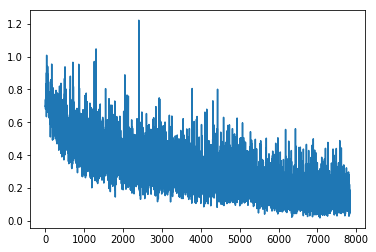

In [31]:
plt.plot(history["train_bce"])

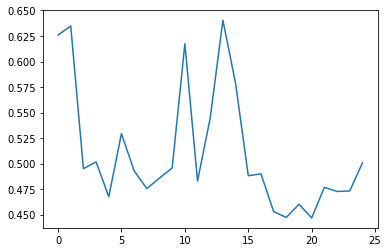

In [30]:
plt.plot(history["val_bce"])

In [33]:
vloss = evaluate(net, vdl, device=gpu)
vloss

BCE: 0.4469


0.44687504158622915

In [34]:
def export():
    torch.save(net, f"{name}-{vloss}.all.pth")
    print('saved model')
export()


saved model


In [ ]:
import gc
try:
    del net
    del tdl
    del vdl
    del optimizer
except:
    pass
torch.cuda.empty_cache()
gc.collect() 


In [ ]:
import json
with open('adjs.json', 'w') as filehandle:
    json.dump(adjs, filehandle)
with open('pnames.json', 'w') as filehandle:
    json.dump(pnames, filehandle)

In [ ]:
with open('adjs.json', 'r') as filehandle:
    adx = json.load(filehandle)
print(adx)

# Experiments log

https://docs.google.com/spreadsheets/d/1lfKEGH5-cUc8vP3E7b3l6FSzUVimPj-6c9ZEgVWJ96o/edit?usp=sharing